## 大綱
+ 1. 套件說明
+ 2. 資料前處理
    + 2.1 基本資料介紹
    + 2.2 資料清理
    + 2.3 文章斷詞
+ 3. lexicon-base 情緒分析
    + 3.1 準備LIWC情緒字典
    + 3.2 情緒字典與斷詞結果進行合併
    + 3.3 正負向情緒分數聲量折線圖圖
    + 3.4 正負向情緒分數比例折線圖圖
    + 3.5 文字雲
    + 3.6 情緒代表字
    + 3.7 每日情緒分數

In [1]:
#改字體

# import matplotlib.font_manager

# a = sorted([f.name for f in matplotlib.font_manager.fontManager.ttflist])

# for i in a:
#     print(i)



In [2]:
from datetime import datetime
from collections import Counter

import pandas as pd
import matplotlib.pyplot as plt 
import matplotlib.font_manager as fm
from matplotlib.colors import Colormap
from wordcloud import WordCloud 
import jieba
%matplotlib inline

plt.rcParams['font.sans-serif'] = ['Taipei Sans TC Beta']
plt.rcParams['axes.unicode_minus'] = False
# 設定整份 notebook 圖片的長寬與 dpi
plt.rcParams["figure.figsize"] = [6, 4]
plt.rcParams["figure.dpi"] = 150

In [3]:
import matplotlib
print(matplotlib.__file__)

d:\anaconda3\lib\site-packages\matplotlib\__init__.py


## 2. 資料前處理

使用「世界棒球經典賽」作為關鍵字，在Tarflow中將 ptt八卦版 資料下載下來

### 2.1 基本資料介紹
- 資料來源: 工作流程蒐集PTT 八卦版 Food 2023-03-08 ~ 2023-03-13 所有文章
- 03/08~03/13正是本次經典賽A組中華隊的賽程

|日期|時間|隊伍(_勝隊_ 敗隊)|比數|
|---|---|---|---|
|3/08(三)|19：00|_**巴拿馬**_ VS 中華隊|12：5|
|3/10(五)|12：00|義大利 VS _**中華隊**_|7：11|
|3/11(六)|19：00|荷蘭 VS _**中華隊**_|5：9|
|3/12(日)|12：00|中華隊 VS _**古巴**_|1：7|


* Tarflow搜尋關鍵字: WBC、世界棒球經典賽、中華隊、啦啦隊、、經典女孩、Major League Baseball、MLB、**中華隊教練名單**、**中華隊球員名單**、**啦啦隊名單**、**基本棒球術語**、**球員教練綽號**

    ```python
    CT_coach = {'林岳平','彭政閔','王建民','高志綱','曾豪駒','許銘傑','陳江和','張建銘','劉品辰'}#中華隊教練名單

    CT_player = {'宋家豪','鄧愷威','王維中','陳冠偉','陳禹勳','陳冠宇','黃子鵬','胡智為','李振昌','呂彥青','吳哲源','江少慶',
                '曾峻岳','陳仕朋','吉力吉撈','鞏冠','林岱安','高宇杰','吳念庭','張育成','林子偉','鄭宗哲','江坤宇','王威晨',
                '范國宸','林立','王柏融','成晉','陳晨威','陳傑憲','郭天信'
                }#中華隊球員名單

    CT_gril = {'峮峮','貴貴','短今','Paggy','妮可','林襄','孟潔','Yuri','籃籃','心璇',
                '小映','賴可','琪琪','艾璐','Yuki','瑟七','Faye','丹丹','秀秀子','奶昔','慈妹'
                }#啦啦隊名單

    baseball_rule = {'安打','全壘打','雙殺','出局','滿貫砲','陽春砲','接殺','漏接','四壞','保送','三振','短打','盜壘'}#基本棒球術語

    nick_name ={'大餅','投手','大王','小玉','二兵','國防部長','三軍統帥','逃兵'}#球員教練綽號

    ```


* 排除關鍵字: 籃球,足球,烏克蘭,俄羅斯,戰爭,核彈,核武,打仗,僵局,統治,中國,八卦,仇恨,二膽,金門,Re:[新聞],黑道

In [4]:
df = pd.read_csv("./data/WBC.csv")
df = df.rename(columns={"artContent": "sentence"})
df.head()

system_id                                             artUrl  \
0          1  https://www.ptt.cc/bbs/Gossiping/M.1678205469....   
1          2  https://www.ptt.cc/bbs/Gossiping/M.1678208423....   
2          3  https://www.ptt.cc/bbs/Gossiping/M.1678208912....   
3          4  https://www.ptt.cc/bbs/Gossiping/M.1678215665....   
4          5  https://www.ptt.cc/bbs/Gossiping/M.1678233314....   

                 artTitle              artDate   artPoster artCatagory  \
0         [問卦]林襄有什麼代表作啊??  2023-03-08 00:11:07   OPPAISuki   Gossiping   
1          Re:[問卦]棒球是過氣了嗎  2023-03-08 01:00:21    richshen   Gossiping   
2  [新聞]「當你害羞人生會錯過許多機會」李維拉  2023-03-08 01:08:30   micheal59   Gossiping   
3        [問卦]熱血主播將轉播這次WBC  2023-03-08 03:01:03     a12c45a   Gossiping   
4      [問卦]中華隊要開始準備抓戰犯了嗎？  2023-03-08 07:55:12  area51gold   Gossiping   

                                            sentence  \
0  都說林襄很紅 現在棒球新聞都是林襄 沒人關心球員\n\n請問一下 林襄 的代表作是什麼啊??...   
1  不是啊\n\n你要不要先看一下售票狀況啊\n\n最貴的一張3200 內野最便宜的2000 連...   
2  備註請放最後面 違者新聞文章刪除\n\n1.媒體來源:自由時報\n\n2.記者署名: 記者羅...   
3  是D 就在今天！\n眾所矚目的\nWBC\n地區分組賽\n就在今天3/8號即將登場\n我們台...   
4  剛好想到\n\n今天經典賽開打\n\n想當然而\n\n經典賽例行的鍋貼想必又要上演\n\n看...   

                                          artComment             e_ip  \
0  [{"cmtStatus": "推", "cmtPoster": "Julian9x9x9"...    36.224.93.130   
1  [{"cmtStatus": "→", "cmtPoster": "andytaso", "...      61.57.148.9   
2  [{"cmtStatus": "推", "cmtPoster": "StylishTrade...     42.77.198.43   
3  [{"cmtStatus": "推", "cmtPoster": "Dinenger", "...  111.242.207.168   
4  [{"cmtStatus": "→", "cmtPoster": "diabolica", ...      42.75.36.33   

          insertedDate dataSource  
0  2023-03-08 01:45:33        ptt  
1  2023-03-08 01:45:47        ptt  
2  2023-03-08 01:45:54        ptt  
3  2023-03-09 01:33:47        ptt  
4  2023-03-09 01:34:17        ptt

In [5]:
clear_df = df.copy()

# 去除有包含空值的筆數
clear_df.dropna(axis=0, how="any", inplace=True)

# 用'。'取代'\n\n'，並移除'\n'
clear_df = clear_df.replace("\\n\\n", "。", regex=True).replace("\n", "", regex=True)

# 移除內文中的網址
clear_df["sentence"] = (
    clear_df["sentence"]
    .replace(r"http\S+", "", regex=True)
    .replace(r"www\S+", "", regex=True)
    .replace(r"\d+", "", regex=True)
)

In [6]:
clear_df["sentence"] = clear_df["sentence"].str.split("[,，。！!？?]{1,}")

sent_df = clear_df.explode("sentence").reset_index(drop=True)

# 把長度小於1的sentence刪掉
sent_df = sent_df[sent_df["sentence"].str.len() > 1]

In [7]:
jieba.set_dictionary("dict/dict.txt")
jieba.load_userdict("dict/user_dict.txt")#自訂義斷詞字典，主要增加中華隊選手名稱+啦啦隊選手名稱以及棒球術語

Building prefix dict from d:\vscode\sna_group1\dict\dict.txt ...
Loading model from cache C:\Users\TSH13\AppData\Local\Temp\jieba.u925c1c7749d424149a79379d27cf7586.cache
Loading model cost 0.396 seconds.
Prefix dict has been built successfully.


In [8]:
sent_df["sentence"] = (
    sent_df["sentence"].str.replace(r"[^\w\s\d]+", "", regex=True).astype(str)
)
sent_df = sent_df[sent_df["sentence"].str.len() > 1]

In [9]:
word_df = (
    sent_df.assign(word=sent_df["sentence"].apply(jieba.lcut))
    .explode("word")
    .drop(["sentence"], axis=1)
)
word_df = word_df.loc[word_df["word"].str.len() > 1]

In [10]:
# 以檔案形式匯入通用的停用字檔案
# 將stopwords存成list
stopwords = [
    line.strip()
    for line in open("dict/stopwords.txt", "r", encoding="utf-8").readlines()
]
#匯入自訂停用詞檔案
for stop in open("dict/user_stopwords.txt", "r", encoding="utf-8").readlines():
    stopwords.append(stop.strip())

In [11]:
noStop_df = word_df[~word_df["word"].isin(stopwords)]
noStop_df.head()

system_id                                             artUrl  \
0          1  https://www.ptt.cc/bbs/Gossiping/M.1678205469....   
0          1  https://www.ptt.cc/bbs/Gossiping/M.1678205469....   
0          1  https://www.ptt.cc/bbs/Gossiping/M.1678205469....   
0          1  https://www.ptt.cc/bbs/Gossiping/M.1678205469....   
0          1  https://www.ptt.cc/bbs/Gossiping/M.1678205469....   

          artTitle              artDate  artPoster artCatagory  \
0  [問卦]林襄有什麼代表作啊??  2023-03-08 00:11:07  OPPAISuki   Gossiping   
0  [問卦]林襄有什麼代表作啊??  2023-03-08 00:11:07  OPPAISuki   Gossiping   
0  [問卦]林襄有什麼代表作啊??  2023-03-08 00:11:07  OPPAISuki   Gossiping   
0  [問卦]林襄有什麼代表作啊??  2023-03-08 00:11:07  OPPAISuki   Gossiping   
0  [問卦]林襄有什麼代表作啊??  2023-03-08 00:11:07  OPPAISuki   Gossiping   

                                          artComment           e_ip  \
0  [{"cmtStatus": "推", "cmtPoster": "Julian9x9x9"...  36.224.93.130   
0  [{"cmtStatus": "推", "cmtPoster": "Julian9x9x9"...  36.224.93.130   
0  [{"cmtStatus": "推", "cmtPoster": "Julian9x9x9"...  36.224.93.130   
0  [{"cmtStatus": "推", "cmtPoster": "Julian9x9x9"...  36.224.93.130   
0  [{"cmtStatus": "推", "cmtPoster": "Julian9x9x9"...  36.224.93.130   

          insertedDate dataSource word  
0  2023-03-08 01:45:33        ptt   林襄  
0  2023-03-08 01:45:33        ptt   很紅  
0  2023-03-08 01:45:33        ptt   現在  
0  2023-03-08 01:45:33        ptt   棒球  
0  2023-03-08 01:45:33        ptt   新聞

In [12]:
noStop_df["word"].value_counts().to_csv("./freq.csv")

## 3. lexicon-base 情緒分析
進行基於情緒字典的情緒分析，首先需要準備情緒字典後再將字典與斷詞後的文章進行合併

### 3.1 準備LIWC字典  
- 全名Linguistic Inquiry and Word Counts，由心理學家Pennebaker於2001出版  
>  就英文版的LIWC2007來說，目前包含了64個定義類別。這些類別包括基本的語文向度類別，例如： 22個語文特性類別（如，代名詞、冠詞等百分比）、3個副語言學（paralinguistic）類別（如應和詞、停頓詞等）。除了已經有具有明確定義的語文類別之外，LIWC也另外包含了32個心理特性類別（如，情感詞、認知詞等）、7個個人化類別（如工作、休閒活動等）。再加上程式自動計算出的6個一般描述性類別（總詞數、每句詞數等）以及12個標點符號類別（如句點、逗點等），總計可輸出80個字詞類別。
- https://cliwc.weebly.com/liwc20073542220856.html 
- https://cliwc.weebly.com/35422208563900621029200131228933521259913549826126.html

In [13]:
# 讀取情緒字典
liwc_dict = pd.read_csv("./dict/liwc/LIWC_CH.csv")
liwc_dict = liwc_dict.rename(columns={'name': 'word', "class": 'sentiments'})
liwc_dict.head()

#######在這邊刪除一些在棒球議題中不算有情緒的詞，例如打擊是單純討論球員的打擊狀況而不是受到打擊
liwc_dict = liwc_dict.drop(liwc_dict[(liwc_dict.word == '擊敗')|(liwc_dict.word == '打擊')|(liwc_dict.word == '打敗')|(liwc_dict.word == '爆發')|(liwc_dict.word == '情緒')].index ,axis=0)
#######

In [14]:
liwc_dict['sentiments'].value_counts()

affect      2056
negative    1167
positive     730
anger        357
sad          191
anx          168
Name: sentiments, dtype: int64

In [15]:
ptt_df = noStop_df.copy()
ptt_df["artDate"] = pd.to_datetime(ptt_df["artDate"])

In [16]:
ptt_df["artDate"].describe(datetime_is_numeric=True)

count                            58638
mean     2023-03-11 05:57:49.451942400
min                2023-03-08 00:11:07
25%                2023-03-09 20:57:34
50%                2023-03-11 12:35:18
75%                2023-03-12 13:17:18
max                2023-03-13 23:59:22
Name: artDate, dtype: object

In [17]:
#因為想看同一天內不同時段的發文數，所以新增一個欄位取得日期並保留帶有時間的"artDate"後，進行分組並得到六天的dataframe

ptt_df["day"] = ptt_df["artDate"].dt.day
ptt_groupbyday_8 = ptt_df.groupby(["day"], as_index=False).get_group(8)
ptt_groupbyday_9 = ptt_df.groupby(["day"], as_index=False).get_group(9)
ptt_groupbyday_10 = ptt_df.groupby(["day"], as_index=False).get_group(10)
ptt_groupbyday_11 = ptt_df.groupby(["day"], as_index=False).get_group(11)
ptt_groupbyday_12 = ptt_df.groupby(["day"], as_index=False).get_group(12)
ptt_groupbyday_13 = ptt_df.groupby(["day"], as_index=False).get_group(13)

## 分析這段幾天，每天0~24時的發文數

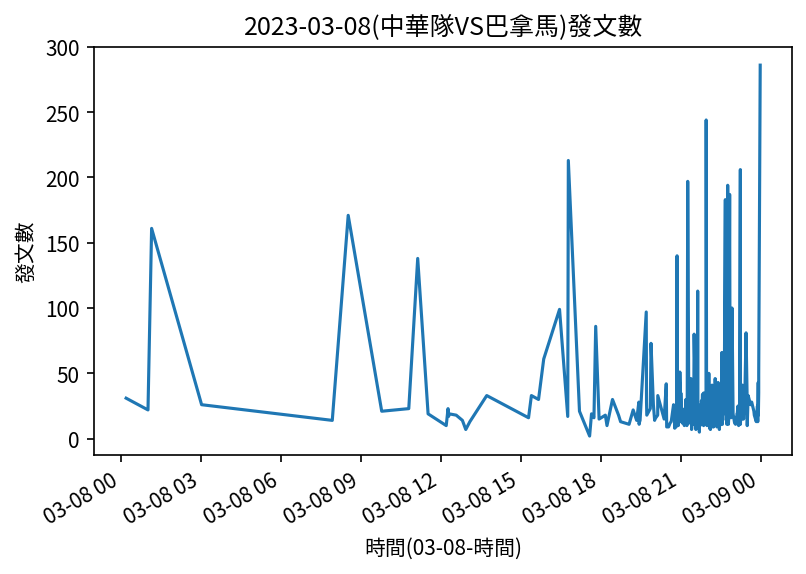

In [18]:
ptt_line_plot = ptt_groupbyday_8.groupby(["artDate"], as_index=False).size()
fig, ax = plt.subplots()

rolling_hours = 1 
ax.plot(ptt_line_plot["artDate"], ptt_line_plot["size"].rolling(rolling_hours).mean())
plt.title('2023-03-08(中華隊VS巴拿馬)發文數')
ax.set_xlabel("時間(03-08-時間)")
ax.set_ylabel('發文數')
fig.autofmt_xdate()
plt.show()

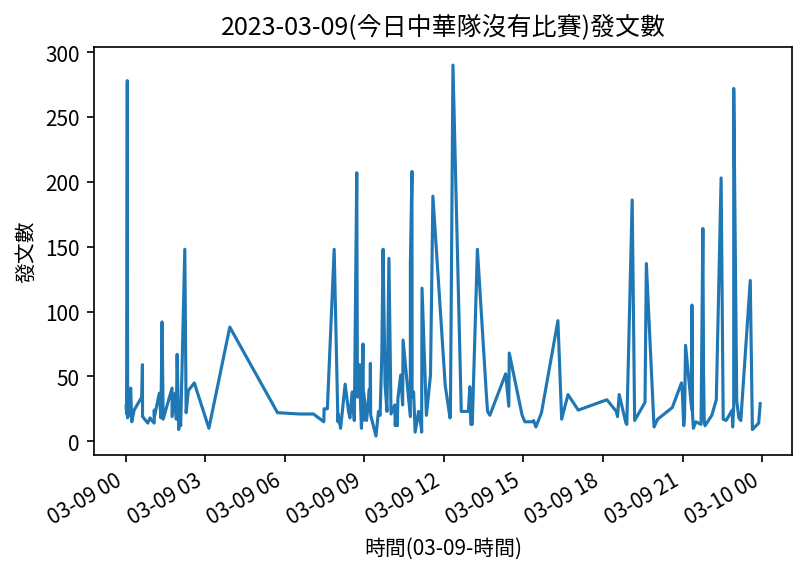

In [19]:
ptt_line_plot = ptt_groupbyday_9.groupby(["artDate"], as_index=False).size()

fig, ax = plt.subplots()
plt.title('2023-03-09(今日中華隊沒有比賽)發文數')
rolling_hours = 1
ax.plot(ptt_line_plot["artDate"], ptt_line_plot["size"].rolling(rolling_hours).mean())
ax.set_xlabel("時間(03-09-時間)")
ax.set_ylabel('發文數')
fig.autofmt_xdate()
plt.show()

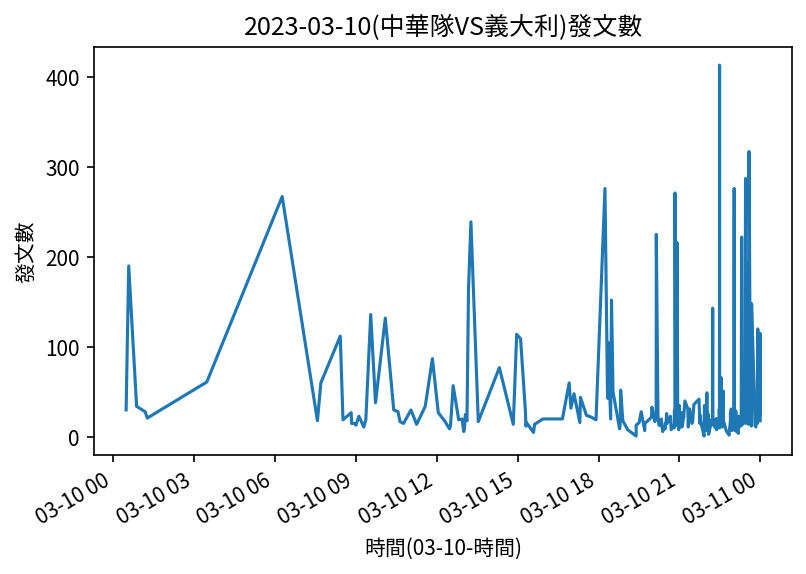

In [20]:
ptt_line_plot = ptt_groupbyday_10.groupby(["artDate"], as_index=False).size()

fig, ax = plt.subplots()
plt.title('2023-03-10(中華隊VS義大利)發文數')
rolling_hours = 1
ax.plot(ptt_line_plot["artDate"], ptt_line_plot["size"].rolling(rolling_hours).mean())
ax.set_xlabel("時間(03-10-時間)")
ax.set_ylabel('發文數')
fig.autofmt_xdate()
plt.show()

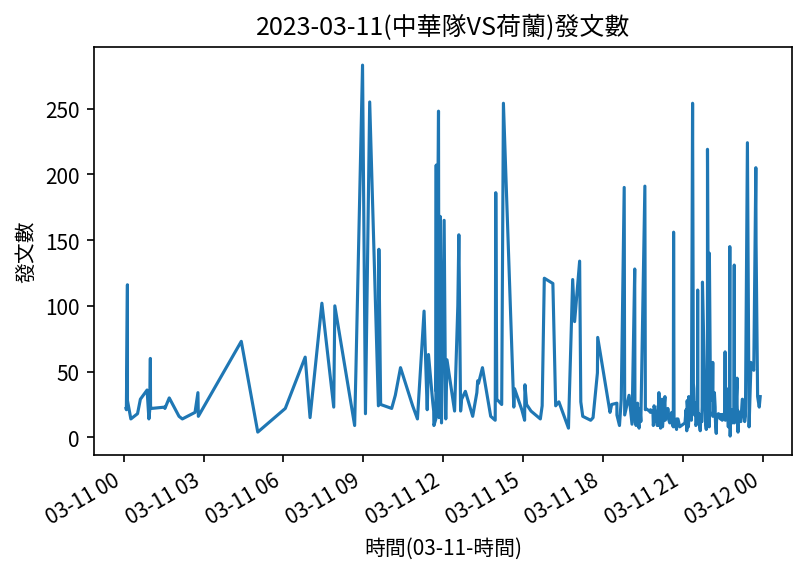

In [21]:
ptt_line_plot = ptt_groupbyday_11.groupby(["artDate"], as_index=False).size()

fig, ax = plt.subplots()
plt.title('2023-03-11(中華隊VS荷蘭)發文數')
rolling_hours = 1
ax.plot(ptt_line_plot["artDate"], ptt_line_plot["size"].rolling(rolling_hours).mean())
ax.set_xlabel("時間(03-11-時間)")
ax.set_ylabel('發文數')
fig.autofmt_xdate()
plt.show()

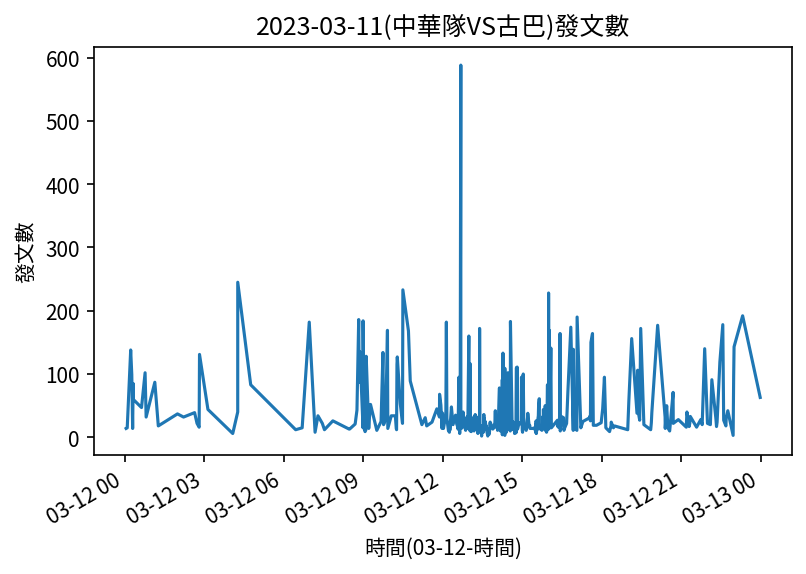

In [22]:
ptt_line_plot = ptt_groupbyday_12.groupby(["artDate"], as_index=False).size()

fig, ax = plt.subplots()
plt.title('2023-03-11(中華隊VS古巴)發文數')
rolling_hours = 1
ax.plot(ptt_line_plot["artDate"], ptt_line_plot["size"].rolling(rolling_hours).mean())
ax.set_xlabel("時間(03-12-時間)")
ax.set_ylabel('發文數')
fig.autofmt_xdate()
plt.show()

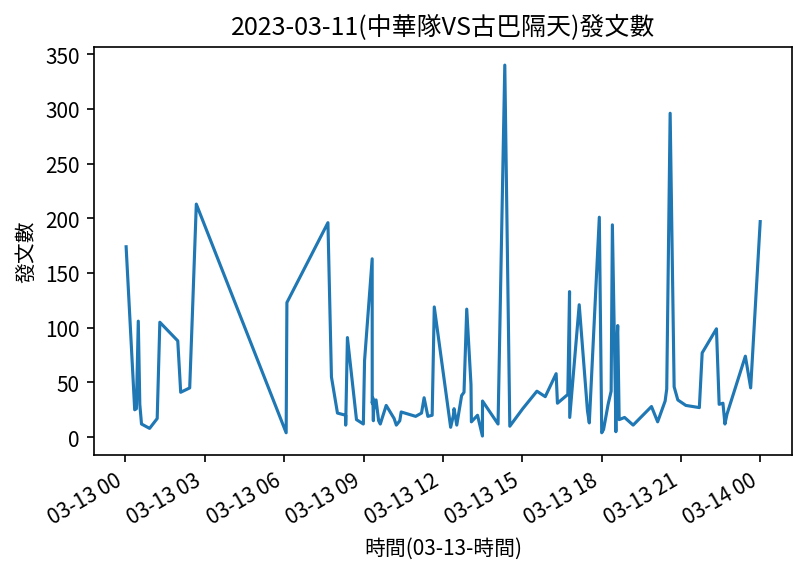

In [23]:
ptt_line_plot = ptt_groupbyday_13.groupby(["artDate"], as_index=False).size()

fig, ax = plt.subplots()
plt.title('2023-03-11(中華隊VS古巴隔天)發文數')
rolling_hours = 1
ax.plot(ptt_line_plot["artDate"], ptt_line_plot["size"].rolling(rolling_hours).mean())
ax.set_xlabel("時間(03-13-時間)")
ax.set_ylabel('發文數')
fig.autofmt_xdate()
plt.show()

* 結果發現這幾天中，發文數最密集的區段剛好與比賽時間吻合
* 而在平日還能發現鄉民們明顯不太發文的區段是睡覺時間，也就是說八卦版鄉民除了睡覺都在使用八卦版(?)

### 3.2 情緒字典與斷詞結果進行合併
將情緒字典與斷詞結果進行合併。。

In [24]:
ptt_liwc_df = pd.merge(ptt_df[["artDate", "artUrl", "word","day"]], liwc_dict, how="left")
ptt_liwc_df

artDate                                             artUrl  \
0     2023-03-08 00:11:07  https://www.ptt.cc/bbs/Gossiping/M.1678205469....   
1     2023-03-08 00:11:07  https://www.ptt.cc/bbs/Gossiping/M.1678205469....   
2     2023-03-08 00:11:07  https://www.ptt.cc/bbs/Gossiping/M.1678205469....   
3     2023-03-08 00:11:07  https://www.ptt.cc/bbs/Gossiping/M.1678205469....   
4     2023-03-08 00:11:07  https://www.ptt.cc/bbs/Gossiping/M.1678205469....   
...                   ...                                                ...   
62236 2023-03-13 23:59:22  https://www.ptt.cc/bbs/Gossiping/M.1678723164....   
62237 2023-03-13 23:59:22  https://www.ptt.cc/bbs/Gossiping/M.1678723164....   
62238 2023-03-13 23:59:22  https://www.ptt.cc/bbs/Gossiping/M.1678723164....   
62239 2023-03-13 23:59:22  https://www.ptt.cc/bbs/Gossiping/M.1678723164....   
62240 2023-03-13 23:59:22  https://www.ptt.cc/bbs/Gossiping/M.1678723164....   

      word  day sentiments  
0       林襄    8        NaN  
1       很紅    8        NaN  
2       現在    8        NaN  
3       棒球    8        NaN  
4       新聞    8        NaN  
...    ...  ...        ...  
62236   表現   13        NaN  
62237   譯者   13        NaN  
62238  戴雅真   13        NaN  
62239   核稿   13        NaN  
62240  林治平   13        NaN  

[62241 rows x 5 columns]

### 3.3 正負向情緒分數聲量折線圖圖
分別畫出文集中，正向（positive）與負向（negative）情緒的折線圖

In [25]:
sentiment_count = pd.DataFrame(
    ptt_liwc_df.groupby(["day", "sentiments"], dropna=False, as_index=False).size()
)
sentiment_count = sentiment_count.rename(columns={0: "size"})
sentiment_count = sentiment_count.sort_values(["day"])
sentiment_count

day sentiments   size
0     8     affect    443
1     8      anger     18
2     8        anx     38
3     8   negative    150
4     8   positive    270
5     8        sad     40
6     8        NaN   8335
13    9        NaN   6939
12    9        sad     32
11    9   positive    249
8     9      anger     44
9     9        anx     28
7     9     affect    416
10    9   negative    145
18   10   positive    268
19   10        sad     19
17   10   negative    172
20   10        NaN   9362
15   10      anger     34
14   10     affect    465
16   10        anx     46
21   11     affect    648
22   11      anger     40
23   11        anx     41
24   11   negative    205
25   11   positive    406
26   11        sad     36
27   11        NaN  10624
34   12        NaN  15052
33   12        sad     59
32   12   positive    537
29   12      anger     70
30   12        anx     46
28   12     affect    904
31   12   negative    293
40   13        sad     20
35   13     affect    300
36   13      anger     18
37   13        anx     13
38   13   negative     83
39   13   positive    183
41   13        NaN   5150

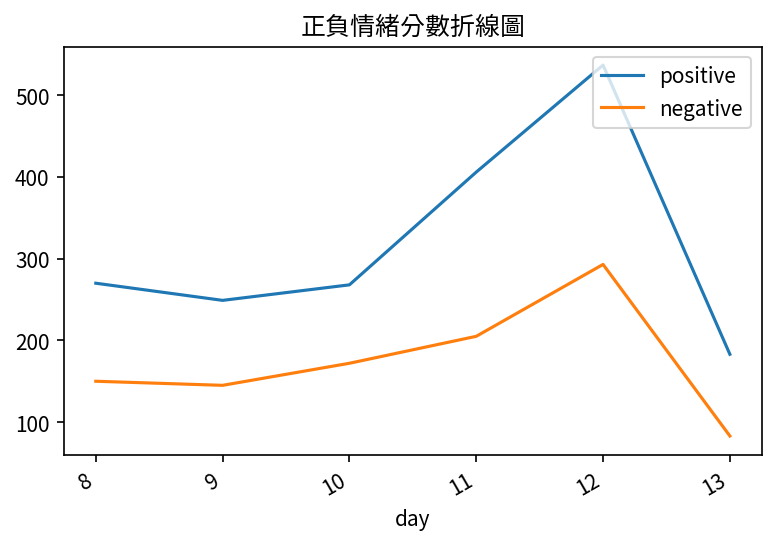

In [26]:
colors = ["tab:blue", "tab:orange"]
pos = sentiment_count[sentiment_count["sentiments"] == "positive"]
neg = sentiment_count[sentiment_count["sentiments"] == "negative"]

# fig, ax = plt.subplots(figsize = (6,4), dpi = 150) # 也可以在該圖設定參數
fig, ax = plt.subplots()

ax.plot(pos["day"], pos["size"], color=colors[0])
ax.plot(neg["day"], neg["size"], color=colors[1])

plt.xlabel("day")
# plt.ylabel('size')
ax.legend(["positive", "negative"], loc="upper right")
fig.autofmt_xdate()
plt.title("正負情緒分數折線圖")  # 記得加上才能顯示中文
plt.show()

* 可以發現大家對於中華隊的感想，不管討論聲量多寡，都是正面情緒大於負面的，不管輸球贏球，再怎麼樣都會支持自己的國家隊。
* 12號的正負聲量都是最高的，因此後續拿12號的資料來做後續分析。


### 3.4 正負向情緒分數比例折線圖圖

In [27]:
sentiment_count = sentiment_count.assign(
    ratio=sentiment_count.groupby("day")["size"].transform(lambda n: n / n.sum())
)
sentiment_count

day sentiments   size     ratio
0     8     affect    443  0.047665
1     8      anger     18  0.001937
2     8        anx     38  0.004089
3     8   negative    150  0.016139
4     8   positive    270  0.029051
5     8        sad     40  0.004304
6     8        NaN   8335  0.896815
13    9        NaN   6939  0.883611
12    9        sad     32  0.004075
11    9   positive    249  0.031708
8     9      anger     44  0.005603
9     9        anx     28  0.003566
7     9     affect    416  0.052973
10    9   negative    145  0.018464
18   10   positive    268  0.025854
19   10        sad     19  0.001833
17   10   negative    172  0.016593
20   10        NaN   9362  0.903145
15   10      anger     34  0.003280
14   10     affect    465  0.044858
16   10        anx     46  0.004438
21   11     affect    648  0.054000
22   11      anger     40  0.003333
23   11        anx     41  0.003417
24   11   negative    205  0.017083
25   11   positive    406  0.033833
26   11        sad     36  0.003000
27   11        NaN  10624  0.885333
34   12        NaN  15052  0.887448
33   12        sad     59  0.003479
32   12   positive    537  0.031661
29   12      anger     70  0.004127
30   12        anx     46  0.002712
28   12     affect    904  0.053299
31   12   negative    293  0.017275
40   13        sad     20  0.003468
35   13     affect    300  0.052020
36   13      anger     18  0.003121
37   13        anx     13  0.002254
38   13   negative     83  0.014392
39   13   positive    183  0.031732
41   13        NaN   5150  0.893012

In [28]:
pos = sentiment_count[sentiment_count["sentiments"] == "positive"]
neg = sentiment_count[sentiment_count["sentiments"] == "negative"]

Text(0.5, 1.0, '正負情緒比例折線圖')

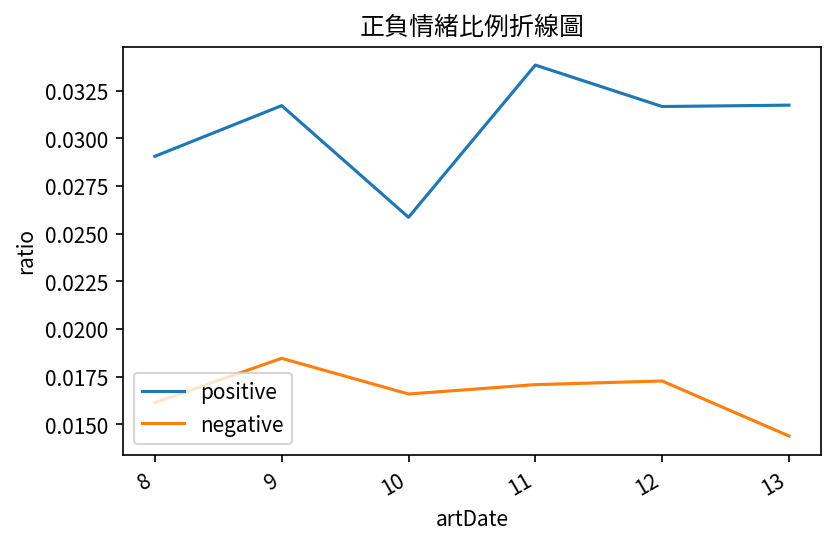

In [29]:
fig, ax = plt.subplots()

rolling_days = 1
ax.plot(pos["day"], pos["ratio"].rolling(rolling_days).mean(), color=colors[0])
ax.plot(neg["day"], neg["ratio"].rolling(rolling_days).mean(), color=colors[1])

plt.xlabel("artDate")
plt.ylabel("ratio")
ax.legend(["positive", "negative"], loc="lower left")
fig.autofmt_xdate()
plt.title("正負情緒比例折線圖")

### 3.5 文字雲
針對不同日期畫出該天的文字雲，如果文字雲中的字詞大小越大，代表出現頻率越高

In [30]:
mask = sentiment_count['sentiments'] == 'positive'
sentiment_count.loc[mask,:].sort_values("size", ascending=False).head()

day sentiments  size     ratio
32   12   positive   537  0.031661
25   11   positive   406  0.033833
4     8   positive   270  0.029051
18   10   positive   268  0.025854
11    9   positive   249  0.031708

####  文字雲


(-0.5, 1599.5, 799.5, -0.5)

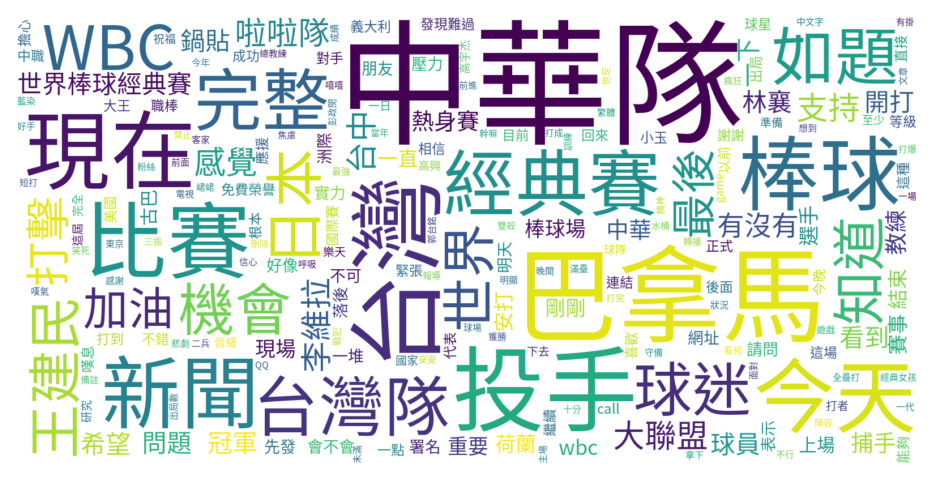

In [31]:
date = 8
mask = (ptt_liwc_df['day'] == date)
ptt_df_wc_8 = ptt_liwc_df.loc[mask, ["artDate", "word"]]
wc_8 = ptt_df_wc_8.groupby(["word"]).size().to_dict()

# wordcloud 的 input 是 dictionary
font_path = "./SourceHanSansTW-Regular.otf"  # 中文字型路徑
cloud = WordCloud(scale=4,max_words=200, background_color="white",font_path=font_path)
cloud.generate_from_frequencies(wc_8)
# 繪圖
plt.figure(figsize=(8, 4), dpi=150)
plt.imshow(cloud, interpolation="bilinear")
plt.axis("off")
# plt.show()

(-0.5, 1599.5, 799.5, -0.5)

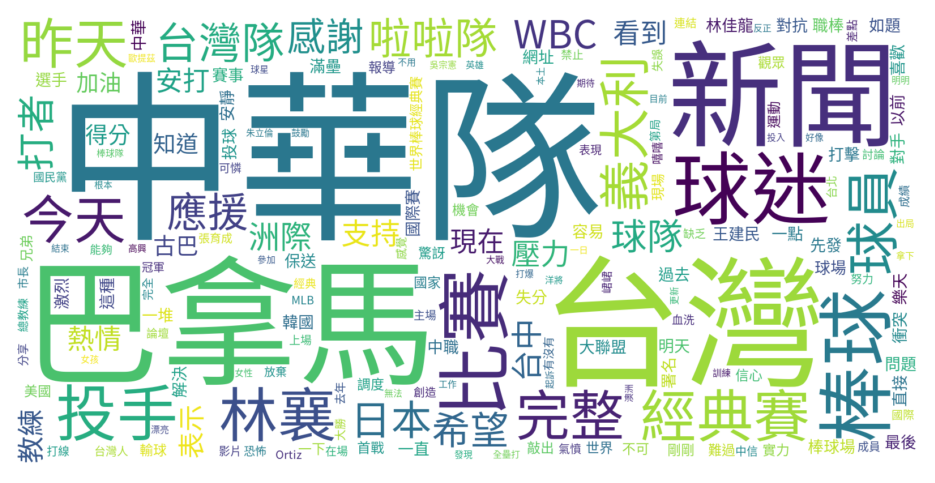

In [32]:
date = 9
mask = (ptt_liwc_df['day'] == date)
ptt_df_wc_9 = ptt_liwc_df.loc[mask, ["artDate", "word"]]
wc_9 = ptt_df_wc_9.groupby(["word"]).size().to_dict()
# wordcloud 的 input 是 dictionary
font_path = "./SourceHanSansTW-Regular.otf"  # 中文字型路徑
cloud = WordCloud(scale=4,max_words=200, background_color="white",font_path=font_path)
cloud.generate_from_frequencies(wc_9)
# 繪圖
plt.figure(figsize=(8, 4), dpi=150)
plt.imshow(cloud, interpolation="bilinear")
plt.axis("off")
# plt.show()

(-0.5, 1599.5, 799.5, -0.5)

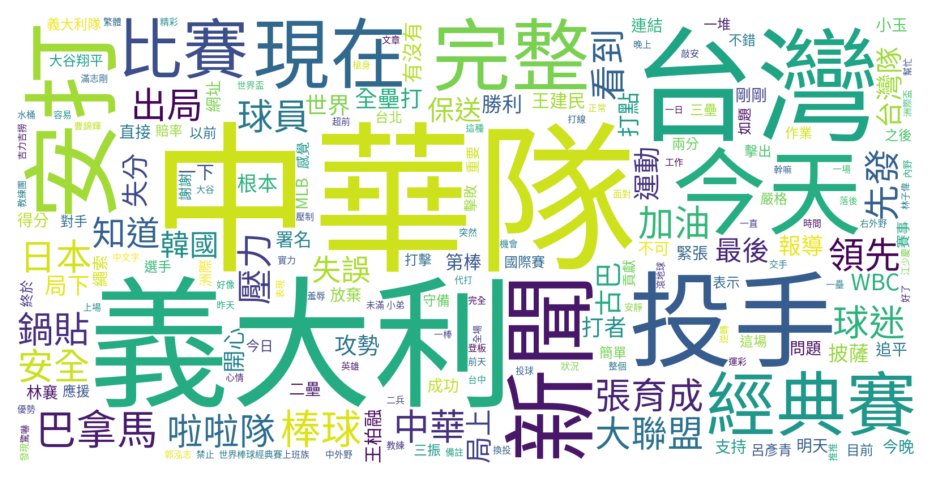

In [33]:
date = 10
mask = (ptt_liwc_df['day'] == date)
ptt_df_wc_10 = ptt_liwc_df.loc[mask, ["artDate", "word"]]
wc_10 = ptt_df_wc_10.groupby(["word"]).size().to_dict()
# wordcloud 的 input 是 dictionary
font_path = "./SourceHanSansTW-Regular.otf"  # 中文字型路徑
cloud = WordCloud(scale=4,max_words=200, background_color="white",font_path=font_path)
cloud.generate_from_frequencies(wc_10)
# 繪圖
plt.figure(figsize=(8, 4), dpi=150)
plt.imshow(cloud, interpolation="bilinear")
plt.axis("off")
# plt.show()

(-0.5, 1599.5, 799.5, -0.5)

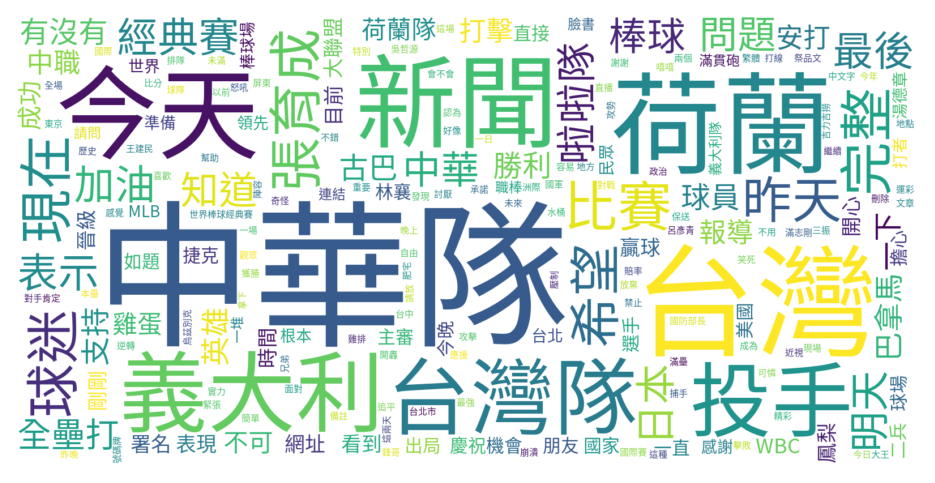

In [34]:
date = 11
mask = (ptt_liwc_df['day'] == date)
ptt_df_wc_11 = ptt_liwc_df.loc[mask, ["artDate", "word"]]
wc_11 = ptt_df_wc_11.groupby(["word"]).size().to_dict()
# wordcloud 的 input 是 dictionary
font_path = "./SourceHanSansTW-Regular.otf"  # 中文字型路徑
cloud = WordCloud(scale=4,max_words=200, background_color="white",font_path=font_path)
cloud.generate_from_frequencies(wc_11)
# 繪圖
plt.figure(figsize=(8, 4), dpi=150)
plt.imshow(cloud, interpolation="bilinear")
plt.axis("off")
# plt.show()

(-0.5, 1599.5, 799.5, -0.5)

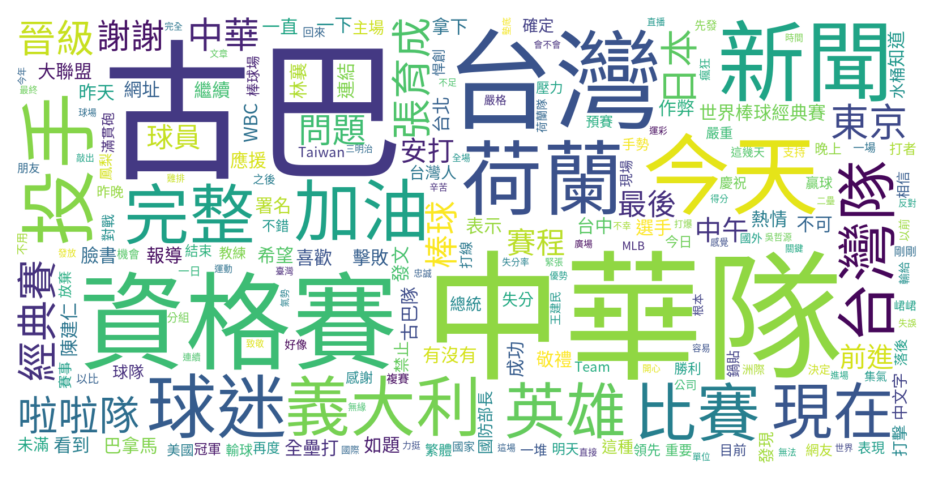

In [35]:
date = 12
mask = (ptt_liwc_df['day'] == date)
ptt_df_wc_12 = ptt_liwc_df.loc[mask, ["artDate", "word"]]
wc_12 = ptt_df_wc_12.groupby(["word"]).size().to_dict()
# wordcloud 的 input 是 dictionary
font_path = "./SourceHanSansTW-Regular.otf"  # 中文字型路徑
cloud = WordCloud(scale=4,max_words=200, background_color="white",font_path=font_path)
cloud.generate_from_frequencies(wc_12)
# 繪圖
plt.figure(figsize=(8, 4), dpi=150)
plt.imshow(cloud, interpolation="bilinear")
plt.axis("off")
# plt.show()

(-0.5, 1599.5, 799.5, -0.5)

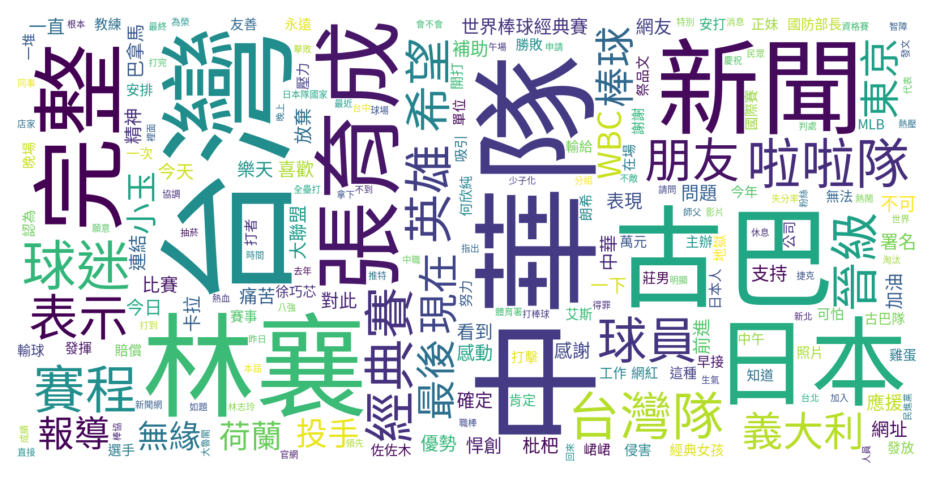

In [36]:
date = 13
mask = (ptt_liwc_df['day'] == date)
ptt_df_wc_13 = ptt_liwc_df.loc[mask, ["artDate", "word"]]
wc_13 = ptt_df_wc_13.groupby(["word"]).size().to_dict()
# wordcloud 的 input 是 dictionary
font_path = "./SourceHanSansTW-Regular.otf"  # 中文字型路徑
cloud = WordCloud(scale=4,max_words=200, background_color="white",font_path=font_path)
cloud.generate_from_frequencies(wc_13)
# 繪圖
plt.figure(figsize=(8, 4), dpi=150)
plt.imshow(cloud, interpolation="bilinear")
plt.axis("off")
# plt.show()

* 賽前大家都看好中華隊可以拿下巴拿馬，以實力來說中華隊略勝一籌，但該場比賽中華隊慘敗，甚至被打了12分，照理說文字雲應該要很不友善，但看起來沒有特別的地方，只有出現鍋貼一詞較為特別(鍋貼 : 輸球常說雖敗猶榮(遊龍)，所以鄉民把鍋貼引申為是輸球)
* 9號因為當日沒比賽，所以關鍵字巴拿馬還是很大一個，而隔天的對手義大利出現的頻繁度也高，有趣的地方在於啦啦隊的林襄跟"啦啦隊"這個詞很顯眼，還有出現王建民(在調侃投手被打爆，叫教練來投都比較好)、韓國跟日本(隔天比賽除了中華隊以外還有棒球界經典的日韓大戰)
* 10號面對強敵義大利，今日的文字雲主要出現中華隊、台灣、義大利，比較有趣的是出現了王柏融以及小玉，王柏融的表現非常不如預期因此被鄉民取綽號小玉(取本來綽號"大王"的相反)，另外還有上面提到的韓國、日本以及日本隊的超人氣球星大谷翔平。
* 11號的文字雲中，中華隊、台灣、荷蘭占了很大的版面，另外是張育成，在11號得到了不少討論，主要是因為在五局的時候張育成打出了本屆WBC的第一支滿貫全壘打。
* 在10、11號取得勝利之後，由於8號慘輸巴拿馬，中華隊今天12號必須打贏強敵古巴才能晉級，是一場win or go home的比賽，因此前面的討論數、情緒量在今天是最多的，也因此後面的分析會以12號為主。
* 13號雖然沒賽程了，但做了今天的文字雲是想看大家討論的熱度，很明顯討論的主題是無緣晉級、本組MVP張育成以及啦啦隊的林襄...

## 3/12之正負情緒文字雲

(-0.5, 1599.5, 799.5, -0.5)

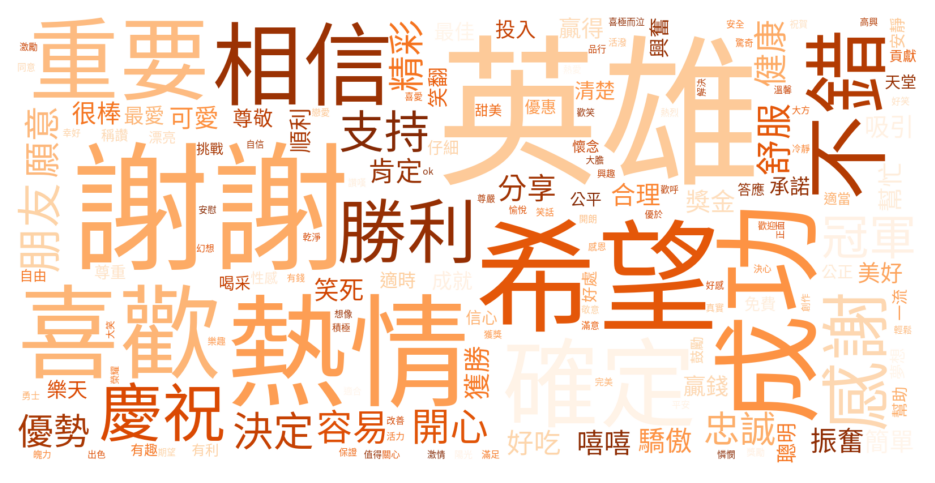

In [37]:
date = 12
mask = (ptt_liwc_df["day"] == date) & (
    ptt_liwc_df["sentiments"] == "positive"
)
ptt_df_wc = ptt_liwc_df.loc[mask, ["artDate", "word"]]
wc = ptt_df_wc.groupby(["word"]).size().to_dict()
Counter(wc).most_common(20)

# wordcloud 的 input 是 dictionary
font_path = "./SourceHanSansTW-Regular.otf"  # 中文字型路徑
cloud = WordCloud(scale=4,max_words=200, background_color="white", font_path=font_path, colormap="Oranges")
cloud.generate_from_frequencies(wc)
# 繪圖
plt.figure(figsize=(8, 4), dpi=150)
plt.imshow(
    cloud, 
    interpolation="bilinear"
)
plt.axis("off")
# plt.show()

(-0.5, 1599.5, 799.5, -0.5)

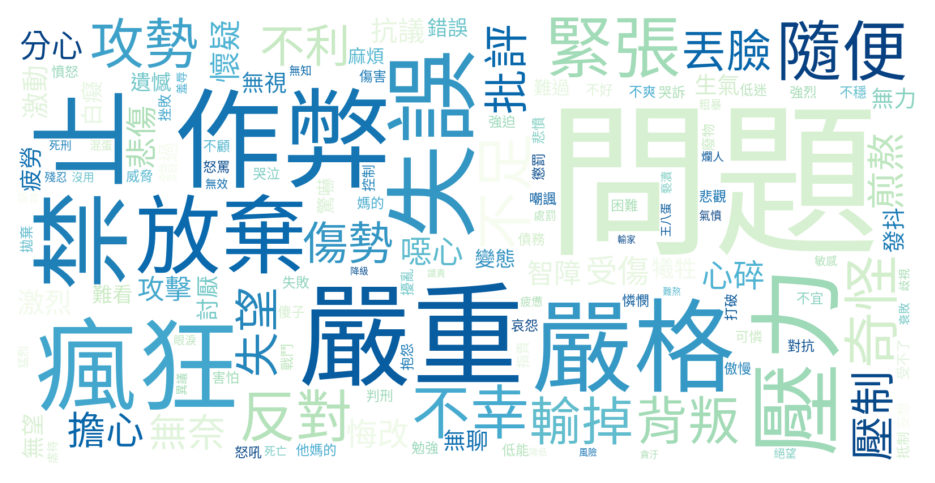

In [38]:
day = 12
mask = (ptt_liwc_df["day"] == day) & (
    ptt_liwc_df["sentiments"] == "negative"
)
ptt_df_wc = ptt_liwc_df.loc[mask, ["artDate", "word"]]
wc = ptt_df_wc.groupby(["word"]).size().to_dict()
Counter(wc).most_common(20)

# wordcloud 的 input 是 dictionary
font_path = "./SourceHanSansTW-Regular.otf"  # 中文字型路徑
cloud = WordCloud(scale=4,max_words=200, background_color="white", font_path=font_path, colormap="GnBu")
cloud.generate_from_frequencies(wc)
# 繪圖
plt.figure(figsize=(8, 4), dpi=150)
plt.imshow(
    cloud, 
    interpolation="bilinear"
)
plt.axis("off")
# plt.show()

### 3.6 情緒代表字
從整個文集中計算出正負向情緒字的出現詞頻，並找出情緒的代表字

In [39]:
word_count = ptt_liwc_df.groupby(["word", "sentiments"]).size().reset_index()
word_count = word_count.rename(columns={0: "size"})
word_count = word_count.sort_values(["size"], ascending=False)
word_count

word sentiments  size
442    希望     affect    80
443    希望   positive    80
277    問題     affect    76
278    問題   negative    76
1114   英雄   positive    72
...   ...        ...   ...
837    混亂        anx     1
838    混亂   negative     1
839    混蛋     affect     1
840    混蛋      anger     1
670    捐贈     affect     1

[1341 rows x 3 columns]

In [40]:
word_of_pos = word_count.loc[(word_count["sentiments"] == "positive")]
word_of_pos

word sentiments  size
443    希望   positive    80
1114   英雄   positive    72
692    支持   positive    59
1167   謝謝   positive    52
607    成功   positive    45
...   ...        ...   ...
862    激情   positive     1
282    善意   positive     1
814    決心   positive     1
284    喜悅   positive     1
835    浪漫   positive     1

[262 rows x 3 columns]

In [41]:
word_of_neg = word_count.loc[(word_count["sentiments"] == "negative")]
word_of_neg

word sentiments  size
278   問題   negative    76
337   壓力   negative    33
361   失誤   negative    31
696   攻勢   negative    25
318   嚴重   negative    24
..   ...        ...   ...
868   灰心   negative     1
841   混蛋   negative     1
816   沉重   negative     1
830   流淚   negative     1
838   混亂   negative     1

[288 rows x 3 columns]

In [42]:
word_of_neg.sort_values(
    ["size"], ascending=False
)

word sentiments  size
278    問題   negative    76
337    壓力   negative    33
361    失誤   negative    31
696    攻勢   negative    25
318    嚴重   negative    24
...   ...        ...   ...
1229   過失   negative     1
1141   褻瀆   negative     1
115    傲慢   negative     1
1118   荒謬   negative     1
838    混亂   negative     1

[288 rows x 3 columns]

C:\Users\TSH13\AppData\Local\Temp/ipykernel_6080/3164965901.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_yticklabels(pos["word"])
C:\Users\TSH13\AppData\Local\Temp/ipykernel_6080/3164965901.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels(neg["word"])


Text(0.5, 1.0, '負向情緒總數')

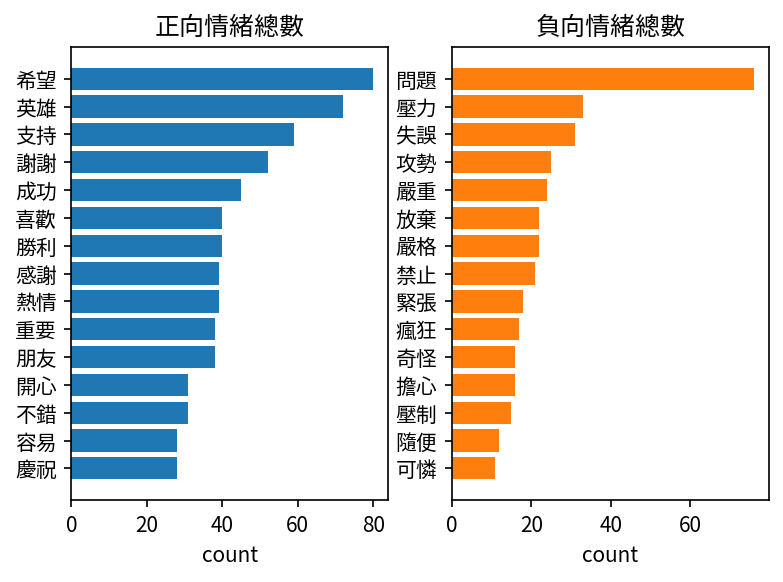

In [43]:
pos = word_of_pos.sort_values(
    ["size"], ascending=True
).iloc[-15:,:]
neg = word_of_neg.sort_values(
    ["size"], ascending=True
).iloc[-15:,:]

fig, ax = plt.subplots(1, 2)

ax[0].barh(pos["word"], pos["size"], color=colors[0])
ax[0].set_xlabel("count")
ax[0].set_yticklabels(pos["word"])
ax[0].set_title("正向情緒總數")

ax[1].barh(neg["word"], neg["size"], color=colors[1])
ax[1].set_xlabel("count")
ax[1].set_yticklabels(neg["word"])
ax[1].set_title("負向情緒總數")

#### 2022-03-12	 正負情緒代表字

In [44]:
sentiment_count[sentiment_count["sentiments"] == "negative"].sort_values('size', ascending=False)

day sentiments  size     ratio
31   12   negative   293  0.017275
24   11   negative   205  0.017083
17   10   negative   172  0.016593
3     8   negative   150  0.016139
10    9   negative   145  0.018464
38   13   negative    83  0.014392

In [45]:
day = 12
mask = (ptt_liwc_df['day'] == day) & (
    ptt_liwc_df["sentiments"].isin(['positive', 'negative'])
)

ptt_df_date = ptt_liwc_df.loc[mask, [ "word", "sentiments","day"]]
ptt_df_date_senti = ptt_df_date.groupby(["sentiments", "word"], as_index=False).size()
ptt_df_date_senti.head()

sentiments word  size
0   negative   不利     3
1   negative   不好     1
2   negative   不宜     1
3   negative   不幸     4
4   negative   不爽     1

C:\Users\TSH13\AppData\Local\Temp/ipykernel_6080/3100566240.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_yticklabels(pos["word"])
C:\Users\TSH13\AppData\Local\Temp/ipykernel_6080/3100566240.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels(neg["word"])


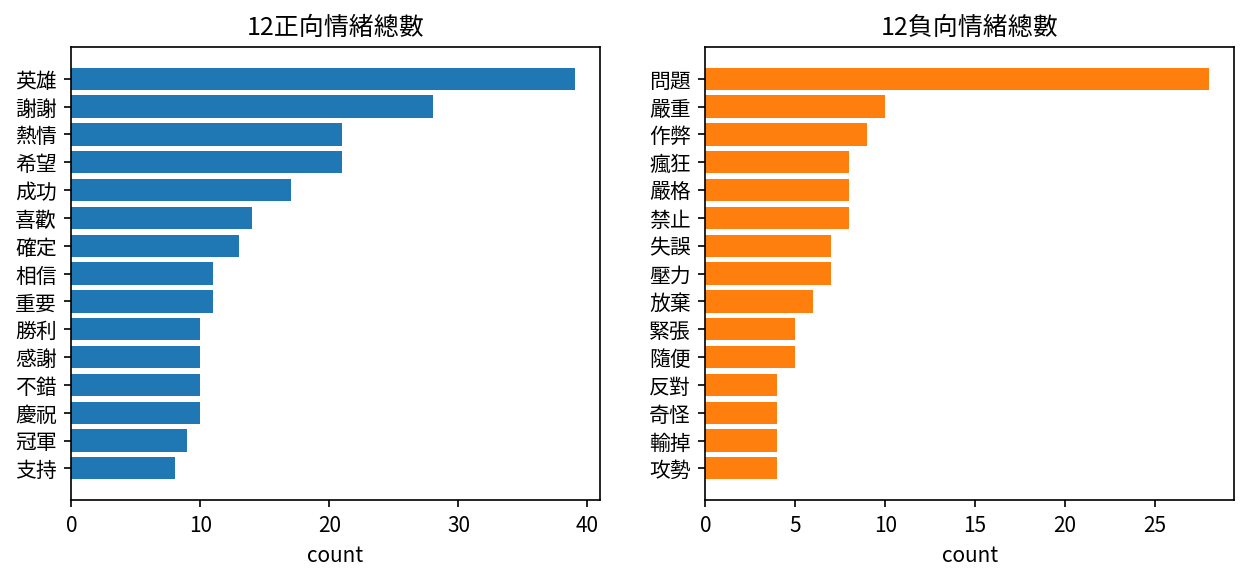

In [46]:
pos = ptt_df_date_senti[(ptt_df_date_senti["sentiments"] == "positive")].sort_values(
    ["size"], ascending=True
)
pos = pos[-15:]
neg = ptt_df_date_senti[ptt_df_date_senti["sentiments"] == "negative"].sort_values(
    ["size"], ascending=True
)
neg = neg[-15:]
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].barh(pos["word"], pos["size"], color=colors[0])
ax[0].set_xlabel("count")
ax[0].set_title(f"{day}正向情緒總數")
ax[0].set_yticklabels(pos["word"])

ax[1].barh(neg["word"], neg["size"], color=colors[1])
ax[1].set_xlabel("count")
ax[1].set_title(f"{day}負向情緒總數")
ax[1].set_yticklabels(neg["word"])
plt.show()

### 3.7 每日情緒分數趨勢

In [47]:
sentiment_count

day sentiments   size     ratio
0     8     affect    443  0.047665
1     8      anger     18  0.001937
2     8        anx     38  0.004089
3     8   negative    150  0.016139
4     8   positive    270  0.029051
5     8        sad     40  0.004304
6     8        NaN   8335  0.896815
13    9        NaN   6939  0.883611
12    9        sad     32  0.004075
11    9   positive    249  0.031708
8     9      anger     44  0.005603
9     9        anx     28  0.003566
7     9     affect    416  0.052973
10    9   negative    145  0.018464
18   10   positive    268  0.025854
19   10        sad     19  0.001833
17   10   negative    172  0.016593
20   10        NaN   9362  0.903145
15   10      anger     34  0.003280
14   10     affect    465  0.044858
16   10        anx     46  0.004438
21   11     affect    648  0.054000
22   11      anger     40  0.003333
23   11        anx     41  0.003417
24   11   negative    205  0.017083
25   11   positive    406  0.033833
26   11        sad     36  0.003000
27   11        NaN  10624  0.885333
34   12        NaN  15052  0.887448
33   12        sad     59  0.003479
32   12   positive    537  0.031661
29   12      anger     70  0.004127
30   12        anx     46  0.002712
28   12     affect    904  0.053299
31   12   negative    293  0.017275
40   13        sad     20  0.003468
35   13     affect    300  0.052020
36   13      anger     18  0.003121
37   13        anx     13  0.002254
38   13   negative     83  0.014392
39   13   positive    183  0.031732
41   13        NaN   5150  0.893012

In [48]:
ptt_sentiment_value = (
    sentiment_count.pivot_table(
        index="day", columns="sentiments", values="size", fill_value=0
    )
    .reset_index()
    .rename_axis(None, axis=1)
)
ptt_sentiment_value.head()

day  affect  anger  anx  negative  positive  sad
0    8     443     18   38       150       270   40
1    9     416     44   28       145       249   32
2   10     465     34   46       172       268   19
3   11     648     40   41       205       406   36
4   12     904     70   46       293       537   59

In [49]:
# sentiment 計算方式: positive - anger - anx - negative - sad
ptt_sentiment_value["sentiment_value"] = (
    ptt_sentiment_value["positive"]
    - ptt_sentiment_value["anger"]
    - ptt_sentiment_value["anx"]
    - ptt_sentiment_value["negative"]
    - ptt_sentiment_value["sad"]
)
ptt_sentiment_value.head()

day  affect  anger  anx  negative  positive  sad  sentiment_value
0    8     443     18   38       150       270   40               24
1    9     416     44   28       145       249   32                0
2   10     465     34   46       172       268   19               -3
3   11     648     40   41       205       406   36               84
4   12     904     70   46       293       537   59               69

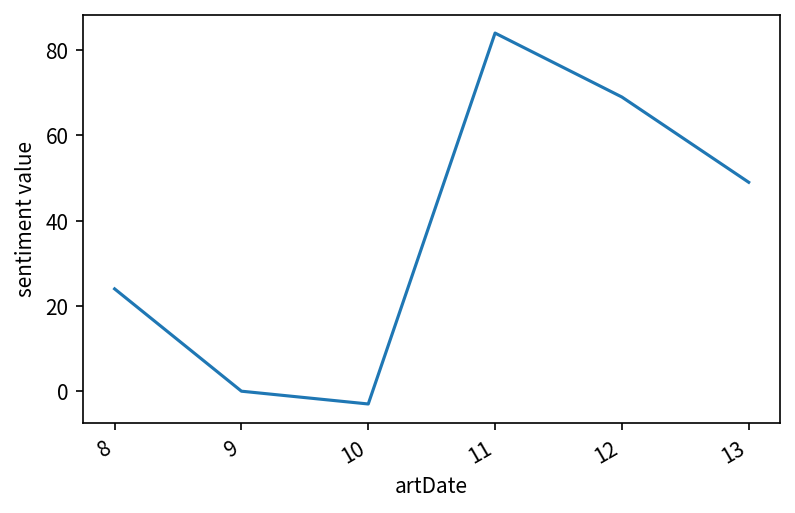

In [50]:
fig, ax = plt.subplots()

rolling_days = 1
ax.plot(ptt_sentiment_value["day"], ptt_sentiment_value["sentiment_value"].rolling(rolling_days).mean())
ax.set_xlabel("artDate")
ax.set_ylabel("sentiment value")
fig.autofmt_xdate()